## This model will clasify a Tomato leaf has any common disease.
Version 01 :
1. Model : Custom
2. Diseaseses : 
3. Dataset : 

In [14]:
# Import libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [15]:
PATH = 'Datasets//PlantVillage Dataset//Tomato'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANELS = 3
EPOCHS = 60

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [17]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [18]:
N_CLASSES = len(class_names)
N_CLASSES

10

2025-12-27 04:08:52.868374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


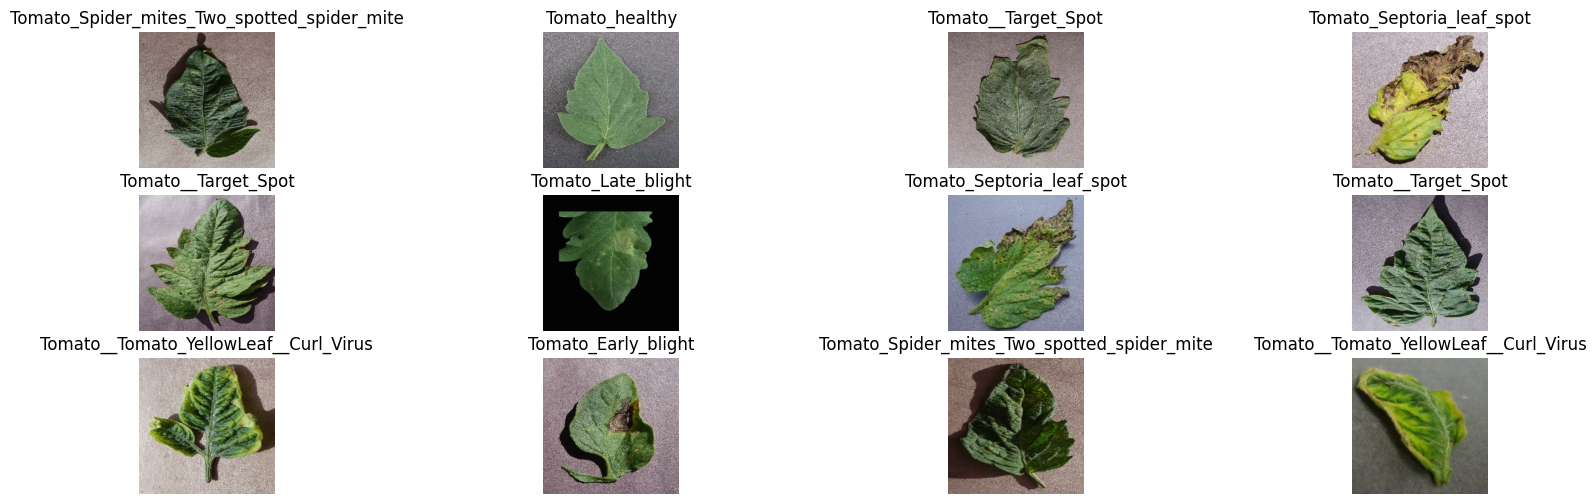

In [19]:
plt.figure(figsize=(20,6))

for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]])
        plt.axis('off')

In [20]:
#Split the data set into train, test and validation sets.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    num_batches = len(ds)
    train_size = int(num_batches*train_split)
    val_size = int(num_batches*val_split)

    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print('Data partitions are created.')
    print(f'Train size = {len(train_ds)} \nValidation size = {len(val_ds)} \nTest size = {len(test_ds)}')

    return train_ds, val_ds, test_ds

In [21]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

Data partitions are created.
Train size = 400 
Validation size = 50 
Test size = 51


In [22]:
#Set datasets to be cached and work with multi processing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
#Resize any given image to 256x256 and sacle teh image values to 0:1

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
])

In [25]:
def save_model(model, name, model_version):
    model.save(f'Models//{name}//{model_version}.keras')
    print('Model saved succesfully')

### Model bulding, Training and Evaluating

### Transferd Model

In [26]:
from tensorflow.keras.applications import MobileNetV2


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = True


fine_tune_at = 100 


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_1 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    data_augmentation,
    
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Increased dropout to fight overfitting
    layers.Dense(N_CLASSES, activation="softmax")
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
)

history_model_1 = model_1.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[lr_scheduler]
)

save_model(model_1, 'tomato_common_diseases_final_models', '1')

/var/folders/6h/fpw492hx5gvg9pp1vflms7y40000gn/T/ipykernel_40970/230123545.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


Epoch 1/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 167s 364ms/step - accuracy: 0.7676 - loss: 0.7072 - val_accuracy: 0.2788 - val_loss: 13.0755 - learning_rate: 0.0010
Epoch 2/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 157s 393ms/step - accuracy: 0.9058 - loss: 0.2788 - val_accuracy: 0.2925 - val_loss: 13.8422 - learning_rate: 0.0010
Epoch 3/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 154s 384ms/step - accuracy: 0.9274 - loss: 0.2185 - val_accuracy: 0.4325 - val_loss: 9.3431 - learning_rate: 0.0010
Epoch 4/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 163s 408ms/step - accuracy: 0.9363 - loss: 0.1854 - val_accuracy: 0.3719 - val_loss: 8.6172 - learning_rate: 0.0010
Epoch 5/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 161s 400ms/step - accuracy: 0.9430 - loss: 0.1619 - val_accuracy: 0.4919 - val_loss: 5.6570 - learning_rate: 0.0010
Epoch 6/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 165s 413ms/step - accuracy: 0.9526 - loss: 0.1470 - val_accuracy: 0.6131 - val_loss: 2.5858 - learning_rate: 0.0010
Epoch 7/60
400/400 ━━━━━━━━━━━━━━━━━━━━ 167s 417ms/step - accu

Text(0.5, 1.0, 'Training and Validation loss')

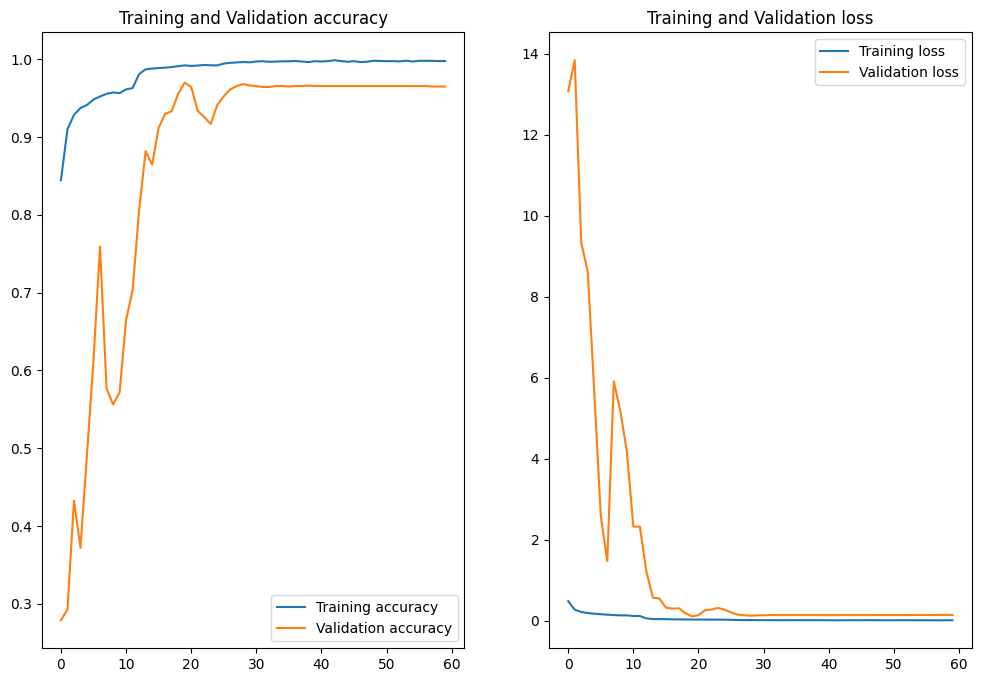

In [31]:
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']

loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [32]:
score = model_1.evaluate(test_ds)
score

51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9708 - loss: 0.0809


[0.08899769932031631, 0.9708255529403687]

#### The model_1 gets 97% accuracy in test sets.

2025-12-27 07:02:36.748689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


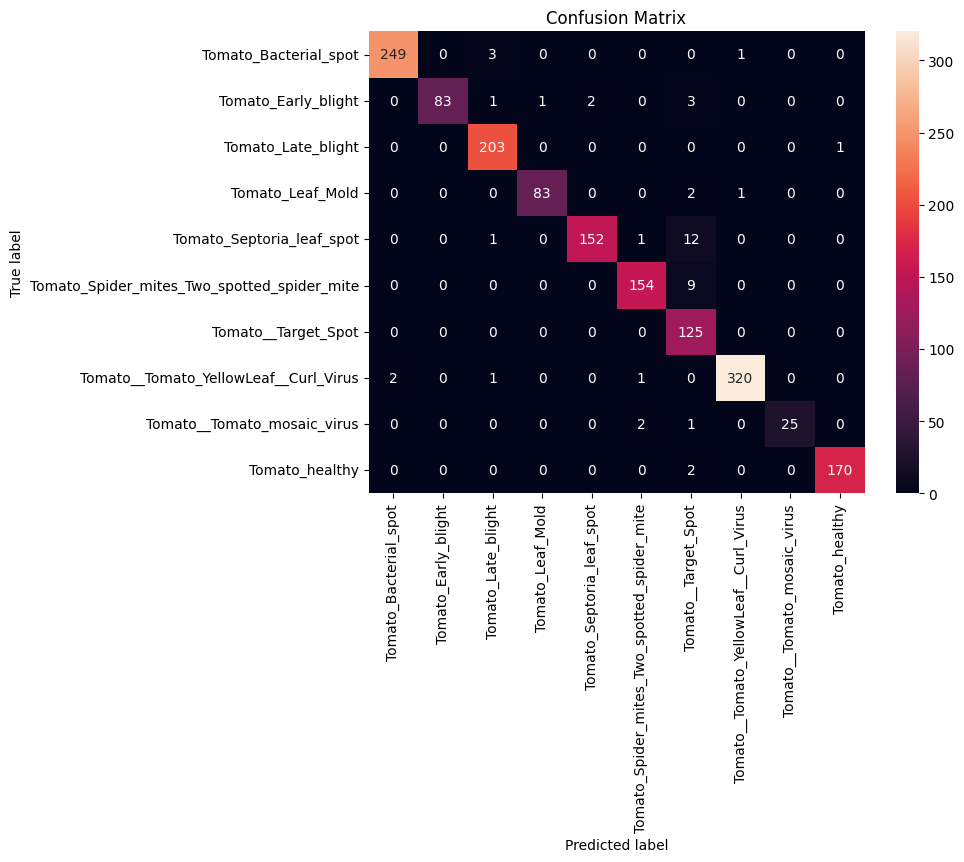

In [33]:
model_1 = tf.keras.models.load_model('Models//tomato_common_diseases_final_models//1.keras')

y_true_list = []
y_pred_list = []

for x_batch, y_batch in test_ds:
    probs = model_1.predict_on_batch(x_batch)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(np.argmax(probs, axis=1))

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns  # if installed

class_names = dataset.class_names  # from image_dataset_from_directory

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()